In [2]:
# Cell 1: Imports and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Packages imported successfully!")

Packages imported successfully!


# Dataset Exploration - Safe Markets Analysis

This notebook explores the collected safe markets dataset to answer key questions about market efficiency and probability calibration.


In [8]:
# Cell 2: Load Dataset
df = pd.read_csv('../dataCollection/safe_markets_full_2024_2025.csv')

# Convert closingDate to datetime - handle ISO8601 format with microseconds and timezone
# Use format='mixed' to handle varying datetime formats, or let pandas infer automatically
df['closingDate'] = pd.to_datetime(df['closingDate'], format='mixed', errors='coerce')

# Convert outcome to boolean if needed
if df['outcome'].dtype == 'object':
    df['outcome'] = df['outcome'].map({'True': True, 'False': False})

# Convert outcome to int for calculations (True=1, False=0)
df['outcome_int'] = df['outcome'].astype(int)

# Ensure no duplicates by deduplicating by clobID
df = df.drop_duplicates(subset=["clobID"]).reset_index(drop=True)

print(f"Dataset loaded: {len(df)} markets")
print(f"Date range: {df['closingDate'].min()} to {df['closingDate'].max()}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()


Dataset loaded: 2021 markets
Date range: 2024-01-20 19:01:51+00:00 to 2025-09-29 14:54:01+00:00

Columns: ['market', 'slug', 'clobID', 'closingDate', 'outcome', 'probability48h', 'probability7d', 'volume', 'outcome_int']

First few rows:


,market,slug,clobID,closingDate,outcome,probability48h,probability7d,volume,outcome_int
0,Will there be a US government shutdown by Jan 20?,will-there-be-a-us-government-shutdown-by-jan-20,9166525427870154856870613992402270242829489715...,2024-01-20 19:01:51+00:00,True,0.9815,0.8050,124889.43,1
1,Will Vivek Ramaswamy win the New Hampshire Rep...,will-vivek-ramaswamy-win-the-new-hampshire-rep...,4065604214843693728734021495935478292809853650...,2024-01-24 12:16:59+00:00,True,0.9995,0.9965,381188.35,1
2,Will Asa Hutchinson win the New Hampshire Repu...,will-asa-hutchinson-win-the-new-hampshire-repu...,8426466075997709205026986871829622392166926309...,2024-01-24 12:17:35+00:00,True,0.9995,0.9930,497060.76,1
3,Will Ron DeSantis win the New Hampshire Republ...,will-ron-desantis-win-the-new-hampshire-republ...,5654465939050854839759118767794853868781394761...,2024-01-24 12:17:51+00:00,True,0.9985,0.9945,702175.69,1
4,Will anyone else win the New Hampshire Republi...,will-anyone-else-win-the-new-hampshire-republi...,2909464492542198091637475068390662088139509346...,2024-01-24 12:16:03+00:00,True,0.9995,0.9955,833479.61,1


In [17]:
# Cell 3: Question 1 - Probability Calibration
# What percentage of markets at different probability thresholds actually resolve to expected outcome?

def calculate_binomial_ci(n, p, confidence=0.95):
    """Calculate binomial proportion confidence interval using normal approximation"""
    z = stats.norm.ppf((1 + confidence) / 2)
    se = np.sqrt(p * (1 - p) / n)
    return p - z * se, p + z * se

bands = [
    (0.90, 0.95, "90-95%"),
    (0.95, 0.98, "95-98%"),
    (0.98, 0.99, "98-99%"),
    (0.99, 1.00, "99-100%")
]

calibration_results = []

for low, high, label in bands:
    mask = (df['probability48h'] >= low) & (df['probability48h'] < high)
    band_data = df[mask]
    
    if len(band_data) > 0:
        n = len(band_data)
        wins = band_data['outcome_int'].sum()
        win_rate = wins / n
        expected_rate = band_data['probability48h'].mean()  # Average of actual probabilities in band
        
        # Calculate confidence interval
        ci_low, ci_high = calculate_binomial_ci(n, win_rate)
        
        calibration_results.append({
            'band': label,
            'low': low,
            'high': high,
            'expected_rate': expected_rate,
            'actual_rate': win_rate,
            'n': n,
            'wins': wins,
            'ci_low': ci_low,
            'ci_high': ci_high,
            'difference': win_rate - expected_rate
        })

calibration_df = pd.DataFrame(calibration_results)
print("Probability Calibration Results:")
print(calibration_df.to_string(index=False))


Probability Calibration Results:
   band  low  high  expected_rate  actual_rate    n  wins   ci_low  ci_high  difference
 90-95% 0.90  0.95       0.926841     0.940092  217   204 0.908517 0.971667    0.013251
 95-98% 0.95  0.98       0.966452     0.960396  303   291 0.938437 0.982355   -0.006056
 98-99% 0.98  0.99       0.985672     0.996516  287   286 0.989698 1.003333    0.010843
99-100% 0.99  1.00       0.996591     0.998353 1214  1212 0.996071 1.000634    0.001762


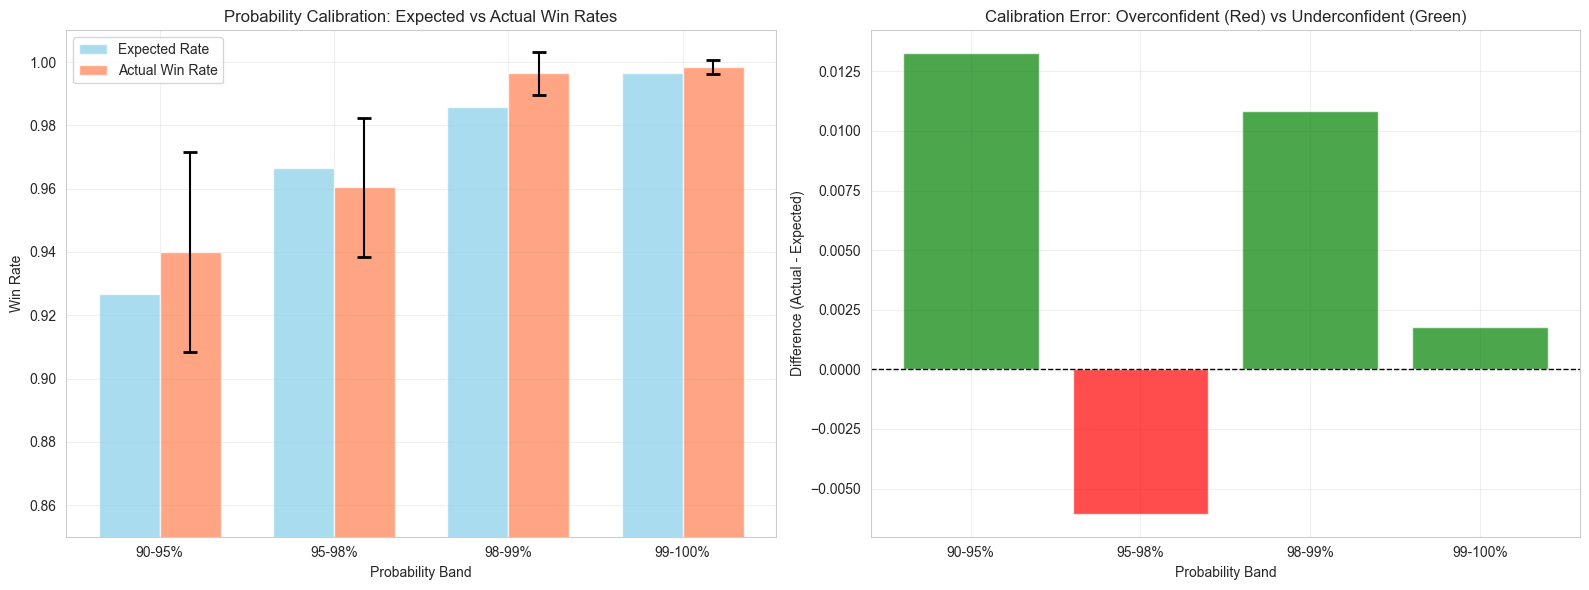

In [19]:
# Cell 4: Visualization 1 - Probability Calibration
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Actual vs Expected Win Rates
x_pos = np.arange(len(calibration_df))
width = 0.35

ax1.bar(x_pos - width/2, calibration_df['expected_rate'], width, label='Expected Rate', alpha=0.7, color='skyblue')
ax1.bar(x_pos + width/2, calibration_df['actual_rate'], width, label='Actual Win Rate', alpha=0.7, color='coral')

# Add error bars for confidence intervals
ax1.errorbar(x_pos + width/2, calibration_df['actual_rate'], 
             yerr=[calibration_df['actual_rate'] - calibration_df['ci_low'], 
                   calibration_df['ci_high'] - calibration_df['actual_rate']],
             fmt='none', color='black', capsize=5, capthick=2)

ax1.set_xlabel('Probability Band')
ax1.set_ylabel('Win Rate')
ax1.set_title('Probability Calibration: Expected vs Actual Win Rates')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(calibration_df['band'])
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0.85, 1.01])

# Plot 2: Difference from Expected
colors = ['green' if x >= 0 else 'red' for x in calibration_df['difference']]
ax2.bar(calibration_df['band'], calibration_df['difference'], color=colors, alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax2.set_xlabel('Probability Band')
ax2.set_ylabel('Difference (Actual - Expected)')
ax2.set_title('Calibration Error: Overconfident (Red) vs Underconfident (Green)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


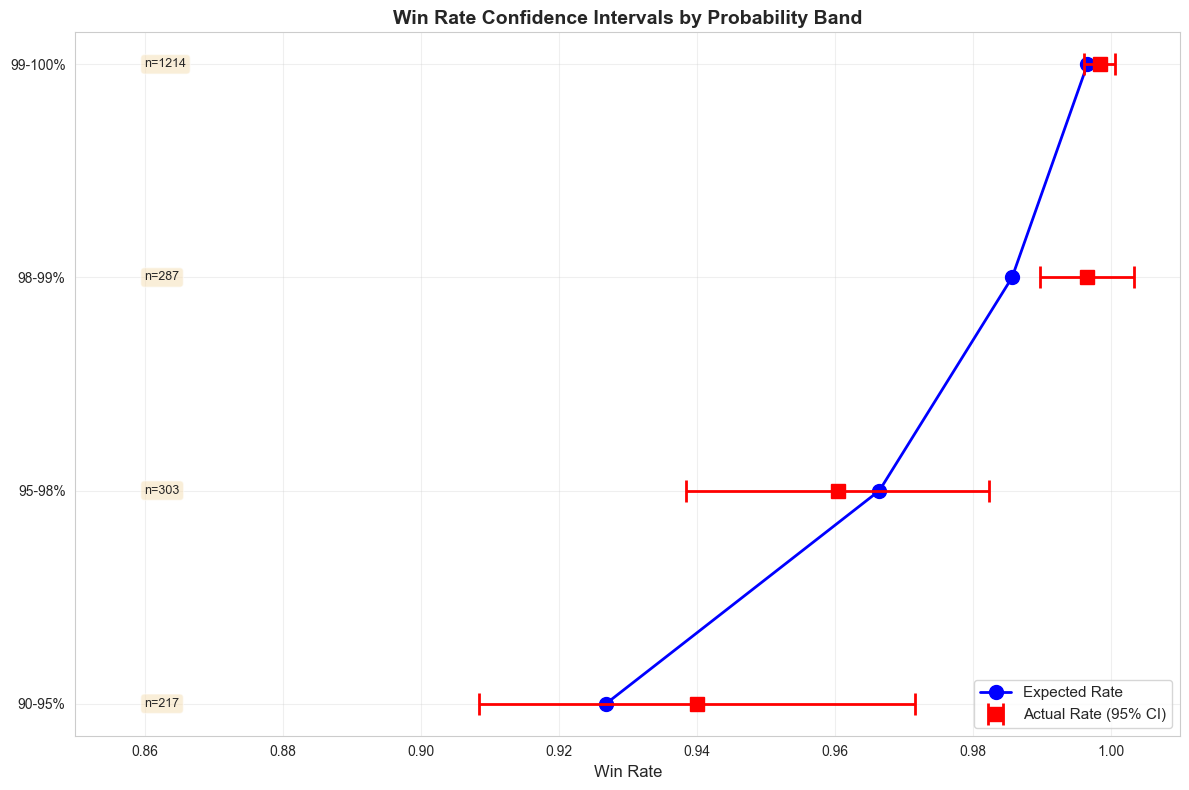

In [20]:
# Cell 5: Question 2 - Confidence Intervals Visualization
fig, ax = plt.subplots(figsize=(12, 8))

# Create confidence interval plot
y_pos = np.arange(len(calibration_df))

# Plot expected rate line
ax.plot(calibration_df['expected_rate'], y_pos, 'o-', label='Expected Rate', 
        color='blue', linewidth=2, markersize=10)

# Plot actual rate with confidence intervals
ax.errorbar(calibration_df['actual_rate'], y_pos, 
            xerr=[calibration_df['actual_rate'] - calibration_df['ci_low'], 
                  calibration_df['ci_high'] - calibration_df['actual_rate']],
            fmt='s', label='Actual Rate (95% CI)', color='red', 
            capsize=8, capthick=2, markersize=10, linewidth=2)

ax.set_yticks(y_pos)
ax.set_yticklabels(calibration_df['band'])
ax.set_xlabel('Win Rate', fontsize=12)
ax.set_title('Win Rate Confidence Intervals by Probability Band', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim([0.85, 1.01])

# Add sample size annotations
for i, row in calibration_df.iterrows():
    ax.text(0.86, i, f'n={row["n"]}', va='center', fontsize=9, 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()


In [21]:
# Cell 6: Question 3 - Time Horizon Analysis
# Compare outcomes based on probability at 48h vs 7d

# Filter out markets with missing 7d data
df_with_7d = df[df['probability7d'].notna()].copy()

# Calculate win rates for different time horizons
win_rate_48h = df['outcome_int'].mean()
win_rate_7d = df_with_7d['outcome_int'].mean()

# Create probability bands for 7d analysis
bands_7d = []
for low, high, label in bands:
    mask = (df_with_7d['probability7d'] >= low) & (df_with_7d['probability7d'] < high)
    band_data = df_with_7d[mask]
    
    if len(band_data) > 0:
        n = len(band_data)
        wins = band_data['outcome_int'].sum()
        win_rate = wins / n
        expected_rate = band_data['probability7d'].mean()  # Average of actual probabilities in band
        
        ci_low, ci_high = calculate_binomial_ci(n, win_rate)
        
        # Get corresponding 48h data for comparison
        mask_48h = (df['probability48h'] >= low) & (df['probability48h'] < high)
        band_data_48h = df[mask_48h]
        win_rate_48h_band = band_data_48h['outcome_int'].mean() if len(band_data_48h) > 0 else None
        n_48h = len(band_data_48h) if len(band_data_48h) > 0 else 0
        
        bands_7d.append({
            'band': label,
            'expected_rate': expected_rate,
            'actual_rate_48h': win_rate_48h_band,
            'actual_rate_7d': win_rate,
            'n_48h': n_48h,
            'n_7d': n,
            'ci_low_7d': ci_low,
            'ci_high_7d': ci_high
        })

time_horizon_df = pd.DataFrame(bands_7d)
print("Time Horizon Comparison (48h vs 7d):")
print(time_horizon_df.to_string(index=False))


Time Horizon Comparison (48h vs 7d):
   band  expected_rate  actual_rate_48h  actual_rate_7d  n_48h  n_7d  ci_low_7d  ci_high_7d
 90-95%       0.928018         0.940092        0.960000    217   250   0.935709    0.984291
 95-98%       0.966790         0.960396        0.983827    303   371   0.970992    0.996663
 98-99%       0.985225         0.996516        0.996805    287   313   0.990553    1.003057
99-100%       0.996054         0.998353        0.998900   1214   909   0.996745    1.001055


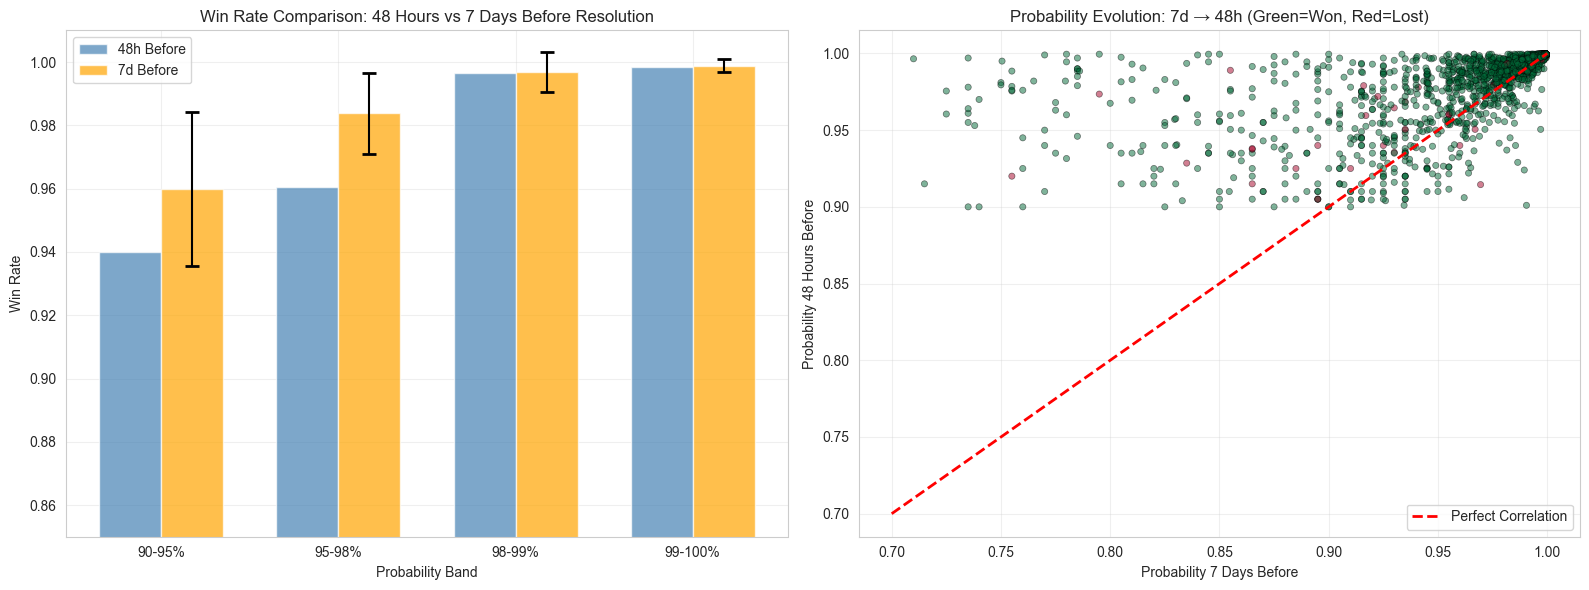

In [22]:
# Cell 7: Visualization 3 - Time Horizon Analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Comparison of 48h vs 7d win rates
x_pos = np.arange(len(time_horizon_df))
width = 0.35

ax1.bar(x_pos - width/2, time_horizon_df['actual_rate_48h'], width, 
        label='48h Before', alpha=0.7, color='steelblue')
ax1.bar(x_pos + width/2, time_horizon_df['actual_rate_7d'], width, 
        label='7d Before', alpha=0.7, color='orange')

# Add error bars for 7d
ax1.errorbar(x_pos + width/2, time_horizon_df['actual_rate_7d'], 
             yerr=[time_horizon_df['actual_rate_7d'] - time_horizon_df['ci_low_7d'], 
                   time_horizon_df['ci_high_7d'] - time_horizon_df['actual_rate_7d']],
             fmt='none', color='black', capsize=5, capthick=2)

ax1.set_xlabel('Probability Band')
ax1.set_ylabel('Win Rate')
ax1.set_title('Win Rate Comparison: 48 Hours vs 7 Days Before Resolution')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(time_horizon_df['band'])
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0.85, 1.01])

# Plot 2: Scatter plot of 48h vs 7d probabilities
ax2.scatter(df_with_7d['probability7d'], df_with_7d['probability48h'], 
           alpha=0.5, s=20, c=df_with_7d['outcome_int'], cmap='RdYlGn', 
           edgecolors='black', linewidths=0.5)
ax2.plot([0.7, 1.0], [0.7, 1.0], 'r--', linewidth=2, label='Perfect Correlation')
ax2.set_xlabel('Probability 7 Days Before')
ax2.set_ylabel('Probability 48 Hours Before')
ax2.set_title('Probability Evolution: 7d → 48h (Green=Won, Red=Lost)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [23]:
# Cell 8: Question 3b - 7-Day Time Horizon Calibration
# Compare expected vs actual win rates for 7-day time horizon

# Filter out markets with missing 7d data
df_with_7d = df[df['probability7d'].notna()].copy()

calibration_7d_results = []

for low, high, label in bands:
    mask = (df_with_7d['probability7d'] >= low) & (df_with_7d['probability7d'] < high)
    band_data = df_with_7d[mask]
    
    if len(band_data) > 0:
        n = len(band_data)
        wins = band_data['outcome_int'].sum()
        win_rate = wins / n
        expected_rate = band_data['probability7d'].mean()  # Average of actual probabilities in band
        
        # Calculate confidence interval
        ci_low, ci_high = calculate_binomial_ci(n, win_rate)
        
        calibration_7d_results.append({
            'band': label,
            'low': low,
            'high': high,
            'expected_rate': expected_rate,
            'actual_rate': win_rate,
            'n': n,
            'wins': wins,
            'ci_low': ci_low,
            'ci_high': ci_high,
            'difference': win_rate - expected_rate
        })

calibration_7d_df = pd.DataFrame(calibration_7d_results)
print("7-Day Time Horizon Calibration Results:")
print(calibration_7d_df.to_string(index=False))


7-Day Time Horizon Calibration Results:
   band  low  high  expected_rate  actual_rate   n  wins   ci_low  ci_high  difference
 90-95% 0.90  0.95       0.928018     0.960000 250   240 0.935709 0.984291    0.031982
 95-98% 0.95  0.98       0.966790     0.983827 371   365 0.970992 0.996663    0.017038
 98-99% 0.98  0.99       0.985225     0.996805 313   312 0.990553 1.003057    0.011580
99-100% 0.99  1.00       0.996054     0.998900 909   908 0.996745 1.001055    0.002846


In [ ]:
# Cell 9: Visualization 3b - 7-Day Time Horizon Calibration
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Actual vs Expected Win Rates for 7d
x_pos = np.arange(len(calibration_7d_df))
width = 0.35

ax1.bar(x_pos - width/2, calibration_7d_df['expected_rate'], width, label='Expected Rate (7d)', alpha=0.7, color='skyblue')
ax1.bar(x_pos + width/2, calibration_7d_df['actual_rate'], width, label='Actual Win Rate (7d)', alpha=0.7, color='coral')

# Add error bars for confidence intervals
ax1.errorbar(x_pos + width/2, calibration_7d_df['actual_rate'], 
             yerr=[calibration_7d_df['actual_rate'] - calibration_7d_df['ci_low'], 
                   calibration_7d_df['ci_high'] - calibration_7d_df['actual_rate']],
             fmt='none', color='black', capsize=5, capthick=2)

ax1.set_xlabel('Probability Band')
ax1.set_ylabel('Win Rate')
ax1.set_title('7-Day Time Horizon: Expected vs Actual Win Rates')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(calibration_7d_df['band'])
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0.85, 1.0])

# Plot 2: Difference from Expected for 7d
colors = ['green' if x >= 0 else 'red' for x in calibration_7d_df['difference']]
ax2.bar(calibration_7d_df['band'], calibration_7d_df['difference'], color=colors, alpha=0.7)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax2.set_xlabel('Probability Band')
ax2.set_ylabel('Difference (Actual - Expected)')
ax2.set_title('7-Day Calibration Error: Overconfident (Red) vs Underconfident (Green)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# Cell 8: Question 4 - Distribution Analysis
# Distribution of probabilities and volume-weighted analysis

# Calculate volume-weighted win rate
volume_weighted_win_rate = (df['outcome_int'] * df['volume']).sum() / df['volume'].sum()
unweighted_win_rate = df['outcome_int'].mean()

print(f"Unweighted Win Rate: {unweighted_win_rate:.4f}")
print(f"Volume-Weighted Win Rate: {volume_weighted_win_rate:.4f}")
print(f"Difference: {volume_weighted_win_rate - unweighted_win_rate:.4f}")


In [ ]:
# Cell 9: Visualization 4 - Distribution Analysis
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Distribution of probabilities
ax1.hist(df['probability48h'], bins=50, alpha=0.7, color='steelblue', edgecolor='black')
ax1.axvline(df['probability48h'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["probability48h"].mean():.3f}')
ax1.axvline(df['probability48h'].median(), color='green', linestyle='--', linewidth=2, label=f'Median: {df["probability48h"].median():.3f}')
ax1.set_xlabel('Probability 48h Before')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Market Probabilities (48h Before)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Win rate by probability bins (calibration curve)
bins = np.linspace(0.90, 1.0, 21)
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_indices = np.digitize(df['probability48h'], bins)

win_rates_by_bin = []
counts_by_bin = []
for i in range(1, len(bins)):
    mask = bin_indices == i
    if mask.sum() > 0:
        win_rates_by_bin.append(df[mask]['outcome_int'].mean())
        counts_by_bin.append(mask.sum())
    else:
        win_rates_by_bin.append(np.nan)
        counts_by_bin.append(0)

ax2.plot(bin_centers, win_rates_by_bin, 'o-', linewidth=2, markersize=6, color='coral')
ax2.plot([0.90, 1.0], [0.90, 1.0], 'r--', linewidth=2, label='Perfect Calibration')
ax2.set_xlabel('Probability 48h Before')
ax2.set_ylabel('Actual Win Rate')
ax2.set_title('Calibration Curve: Probability vs Actual Win Rate')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Volume distribution
ax3.hist(df['volume'], bins=50, alpha=0.7, color='green', edgecolor='black')
ax3.set_xlabel('Volume (USD)')
ax3.set_ylabel('Frequency')
ax3.set_title('Distribution of Market Volumes')
ax3.set_xscale('log')
ax3.grid(True, alpha=0.3)

# Plot 4: Win rate comparison (weighted vs unweighted) by band
weighted_rates = []
unweighted_rates = []
band_labels = []

for low, high, label in bands:
    mask = (df['probability48h'] >= low) & (df['probability48h'] < high)
    band_data = df[mask]
    
    if len(band_data) > 0:
        weighted = (band_data['outcome_int'] * band_data['volume']).sum() / band_data['volume'].sum()
        unweighted = band_data['outcome_int'].mean()
        weighted_rates.append(weighted)
        unweighted_rates.append(unweighted)
        band_labels.append(label)

x_pos = np.arange(len(band_labels))
width = 0.35
ax4.bar(x_pos - width/2, unweighted_rates, width, label='Unweighted', alpha=0.7, color='skyblue')
ax4.bar(x_pos + width/2, weighted_rates, width, label='Volume-Weighted', alpha=0.7, color='orange')
ax4.set_xlabel('Probability Band')
ax4.set_ylabel('Win Rate')
ax4.set_title('Unweighted vs Volume-Weighted Win Rates')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(band_labels)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# Cell 10: Question 5 - Expected Value Calculation
# Calculate expected returns for each probability band

ev_results = []

for low, high, label in bands:
    mask = (df['probability48h'] >= low) & (df['probability48h'] < high)
    band_data = df[mask]
    
    if len(band_data) > 0:
        avg_prob = band_data['probability48h'].mean()
        win_rate = band_data['outcome_int'].mean()
        
        # Calculate actual average return
        # If we invest $1 at price p, we get $1/p shares, worth $1/p if win, $0 if loss
        # Return = (1/p - 1) if win, -1 if loss
        actual_returns = []
        for _, row in band_data.iterrows():
            prob = row['probability48h']
            if row['outcome_int'] == 1:  # Win
                ret = (1.0 / prob) - 1.0
            else:  # Loss
                ret = -1.0
            actual_returns.append(ret)
        
        avg_return = np.mean(actual_returns)
        expected_return_theoretical = 0.0  # Fair market should have 0 expected return
        
        ev_results.append({
            'band': label,
            'avg_probability': avg_prob,
            'win_rate': win_rate,
            'actual_avg_return': avg_return,
            'expected_return_theoretical': expected_return_theoretical,
            'n': len(band_data)
        })

ev_df = pd.DataFrame(ev_results)
print("Expected Value Analysis:")
print(ev_df.to_string(index=False))


In [ ]:
# Cell 11: Visualization 5 - Expected Value Analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Actual Average Returns by Band
ax1.bar(ev_df['band'], ev_df['actual_avg_return'], alpha=0.7, color='steelblue')
ax1.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Expected Return (Fair Market)')
ax1.set_xlabel('Probability Band')
ax1.set_ylabel('Average Return per $1 Invested')
ax1.set_title('Actual Average Returns by Probability Band')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for i, v in enumerate(ev_df['actual_avg_return']):
    ax1.text(i, v + (0.01 if v >= 0 else -0.01), f'{v:.4f}', 
             ha='center', va='bottom' if v >= 0 else 'top', fontweight='bold')

# Plot 2: Return Distribution
all_returns = []
all_bands = []

for low, high, label in bands:
    mask = (df['probability48h'] >= low) & (df['probability48h'] < high)
    band_data = df[mask]
    
    for _, row in band_data.iterrows():
        prob = row['probability48h']
        if row['outcome_int'] == 1:
            ret = (1.0 / prob) - 1.0
        else:
            ret = -1.0
        all_returns.append(ret)
        all_bands.append(label)

returns_df = pd.DataFrame({'return': all_returns, 'band': all_bands})

# Box plot of returns by band
bands_list = [b[2] for b in bands]
returns_by_band = [returns_df[returns_df['band'] == b]['return'].values for b in bands_list]

bp = ax2.boxplot(returns_by_band, labels=bands_list, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
    patch.set_alpha(0.7)

ax2.axhline(y=0, color='red', linestyle='--', linewidth=2)
ax2.set_xlabel('Probability Band')
ax2.set_ylabel('Return per $1 Invested')
ax2.set_title('Return Distribution by Probability Band')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# Cell 12: Summary Statistics Table
print("=" * 70)
print("SUMMARY STATISTICS")
print("=" * 70)

print(f"\nOverall Dataset:")
print(f"  Total Markets: {len(df)}")
print(f"  Overall Win Rate: {df['outcome_int'].mean():.4f} ({df['outcome_int'].sum()}/{len(df)})")
print(f"  Volume-Weighted Win Rate: {volume_weighted_win_rate:.4f}")
print(f"  Average Probability (48h): {df['probability48h'].mean():.4f}")
print(f"  Median Probability (48h): {df['probability48h'].median():.4f}")

print(f"\nBy Probability Band:")
for _, row in calibration_df.iterrows():
    print(f"  {row['band']}:")
    print(f"    Markets: {row['n']}")
    print(f"    Expected Rate: {row['expected_rate']:.4f}")
    print(f"    Actual Rate: {row['actual_rate']:.4f} (95% CI: [{row['ci_low']:.4f}, {row['ci_high']:.4f}])")
    print(f"    Difference: {row['difference']:+.4f}")

print(f"\nExpected Value:")
for _, row in ev_df.iterrows():
    print(f"  {row['band']}: Average Return = {row['actual_avg_return']:+.4f} ({row['actual_avg_return']*100:+.2f}%)")
